Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining
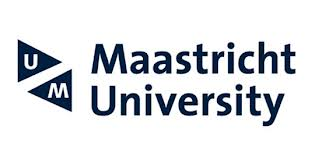
## Notebook 3

Version 2024-2025

Adapted and updated from [here](https://github.com/castorini/anserini-notebooks-afirm2020)

# Indexing


We start by reindexing the dataset as we did in the previous notebook so we can query it:

In [ ]:
!git clone https://github.com/castorini/anserini.git
!cd anserini && git checkout ad5ba1c76196436f8a0e28efdb69960d4873efe3

In [ ]:
!apt-get install -y openjdk-11-jdk-headless
%env JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

In [ ]:
!apt-get install -q maven

In [ ]:
!cd anserini && mvn clean package appassembler:assemble | grep "BUILD"

In [ ]:
!mkdir -p data
!wget https://msmarco.z22.web.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
!tar -xvf collectionandqueries.tar.gz -C data

In [ ]:
!cd anserini && python ./src/main/python/msmarco/convert_collection_to_jsonl.py \
 --collection_path ../data/collection.tsv --output_folder ../data/collection_jsonl

In [ ]:
!cd anserini && sh target/appassembler/bin/IndexCollection -collection JsonCollection -input ../data/collection_jsonl \
 -index ../indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs -generator DefaultLuceneDocumentGenerator -threads 9 \
 -storePositions -storeDocvectors -storeRaw

# Querying

In this exercise, we are going to first interactively query the index and then produce a TREC run with [Pyserini](https://github.com/castorini/pyserini), the Python interface to Anserini.

## Setup

Install Python dependencies (again - remember that each notebook instantiates a virtual machine of its own):

In [ ]:
!pip install pyjnius==1.2.1
!pip install pyserini==0.9.2

Instead of building anserini from scratch, we download the fatjar from the maven repository and store it locally:

In [ ]:
!wget -O anserini-0.9.2-fatjar.jar https://search.maven.org/remotecontent?filepath=io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar

Let's point Pyserini to the Anserini jar that we have just installed:

In [ ]:
import os
os.environ['ANSERINI_CLASSPATH'] = '.'

## Interactive Querying

In [ ]:
from pyserini.search import pysearch
import itertools

The hits data structure holds the docid, the retrieval score, as well as the document content.
Let's look at the top 10 passages for the query `south african football teams`:

In [ ]:
from IPython.core.display import display, HTML

searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
interactive_hits = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits[i].docid, interactive_hits[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

The above example uses default parameters.
Let's try setting tuned parameters for this collection:

In [ ]:
searcher.set_bm25_similarity(0.82, 0.68)
interactive_hits_tuned = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned[i].docid, interactive_hits_tuned[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

###Exercise #1
Compare the rankings with and without tuned parameters.
Add a new cell to query the index with a different query of your choice, both with untuned and tuned parameters.

Note how the ranking has changed.
We can also enable RM3 query expansion to see if it helps with our collection:

In [ ]:
searcher.set_rm3_reranker(10, 10, 0.5)
interactive_hits_tuned_rm3 = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned_rm3[i].docid, interactive_hits_tuned_rm3[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits_tuned_rm3[i].raw + '</div>'))

## Batch Retrieval

Previously we interactively queried the index.
However, in a typical experimental setting, you would evaluate over a larger number of queries to test different information needs.

Let's begin by constructing the dev queries and corresponding query IDs:

In [ ]:
topics = {}
with open('data/queries.dev.small.tsv') as file:
    for line in file:
       id, q = line.strip().split('\t')
       topics[int(id)] = q

print('{} queries total'.format(len(topics)))

In [ ]:
queries = list(topics.values())
qids = list([str(t) for t in topics.keys()])

### Exercise #2
We have previously looked at these queries in the last activity.
Again find the queries that contain `football`.

Now, let's run all the queries from the dev set.
For the sake of speed, let's again only retrieve the top 5 documents for each query.
Note that this step may still take a while.

In [ ]:
searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
bm25_hits = searcher.batch_search(queries, qids, k=5)

Note that the above runs batch retrieval with untuned BM25.
We can repeat with tuned parameters, just like we did for the interactive queries:

In [ ]:
searcher.set_bm25_similarity(0.82, 0.68)
bm25_hits_tuned = searcher.batch_search(queries, qids, k=5)

Now let's repeat with RM3 query expansion (May take a while):

In [ ]:
searcher.set_rm3_reranker(10, 10, 0.5)
bm25_hits_tuned_rm3 = searcher.batch_search(queries, qids, k=5)

### Exercise #3
Produce a run for untuned BM25 with RM3.

### Exercise #4
So far we have downloaded and retrieved the top passages for the dev queries.
Now use the eval queries (data/queries.eval.small.tsv) and repeat the process for eval queries.

## Evaluation

A crucial component of information retrieval research is evaluation and metrics.
The most common tool used to achieve this goal is `trec_eval` developed by [NIST](https://www.nist.gov/).

`trec_eval` defines a number of standard retrieval measures, the details of which can be seen [here](http://www.rafaelglater.com/en/post/learn-how-to-use-trec_eval-to-evaluate-your-information-retrieval-system).

### TREC Format

`trec_eval` requires the runs from various experiments to be expressed in a standard TREC format:

`query_id iter docno rank similarity run_id` delimited by spaces

- `query_id`: query ID
- `iter`: constant, often either 0 or Q0 - required but ignored by `trec_eval`
- `docno`: string values that uniquely identify a document in the collection
- `rank`: integer, often zero indexed
- `similarity`: float value that represents the similarity of the document to the query specified by `query_id`
- `run_id`: string that identifies runs, used to keep track of different experiments - also ignored by `trec_eval`

Evaluation also requires the ground truth in the form of relevance judgements in the qrels file.
The qrels file follows the following format:

`query_id iter docno label`

- `label`: binary code (0 for not relevant and 1 for relevant)

Convert the hits for both BM25 (tuned and untuned) and BM25+RM3 runs into the TREC format:

In [ ]:
def convert_to_trec_run(experiment, run_dict):
  with open('run.{}.txt'.format(experiment), 'w') as run_file:
    for qid in run_dict:
      for rank, doc in enumerate(run_dict[qid]):
        run_file.write('{} Q0 {} {} {} {}\n'.format(qid, doc.docid, rank, doc.score, experiment))

In [ ]:
convert_to_trec_run('msmarco_passage_dev_bm25', bm25_hits)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned', bm25_hits_tuned)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned_rm3', bm25_hits_tuned_rm3)

Let's pull `trec_eval` again:

In [ ]:
!git clone https://github.com/castorini/anserini-tools
!cd anserini-tools/eval && tar xvfz trec_eval.9.0.4.tar.gz && cd trec_eval.9.0.4 && make

In [ ]:
!mv anserini-tools/eval/trec_eval.9.0.4 ./



---



Now that we have our runs in the TREC format, we can evaluate them with `trec_eval`.


In [ ]:
!head -5 run.msmarco_passage_dev_bm25.txt

In [ ]:
!chmod -R +x trec_eval.9.0.4/

In [ ]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25.txt

In [ ]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned.txt

In [ ]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned_rm3.txt

### Exercise #5
What can you infer based on these result?